# Data Exploration

This notebook downloads and explores raw market data guided by the YAML configs in `config/data/`.

**Pipeline stages**:
1. Import libraries and project utilities
2. Ingest or load raw market data (from storage or provider)
3. Basic cleaning (duplicates, missing values)
4. Feature engineering using the project's `FeatureEngineer`
5. Quick visualization and optional persistence to Arctic DB (mock fallback)

In [7]:
# Cell 2: Imports, logging and config checks
import sys
from pathlib import Path
import importlib
import logging
import pandas as pd
import numpy as np

# Ensure project root is on sys.path so `src` imports resolve in the notebook kernel
proj_root = Path("/workspaces/RL_Intraday_Futures_Strategies")
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

from src.utils.config import load_config
from src.utils.logging import setup_logger

logger = setup_logger(__name__, log_file=None)
logger.info('Notebook started')

print('Python', sys.version.split()[0])
for pkg in ('pandas','numpy'):
    m = importlib.import_module(pkg)
    print(pkg, m.__version__)

# Ensure working directory is project root so relative config paths resolve
import os
os.chdir(str(proj_root))

# Load configs (will raise if YAML files not found)
cfg_features = load_config('data/features')
print('Loaded features config keys:', list(cfg_features.keys()))
cfg_ingest = load_config('data/ingestion')
print('Loaded ingestion config keys:', list(cfg_ingest.keys()))

2025-12-07 20:46:47 [INFO] __main__ - Notebook started


Python 3.10.19
pandas 2.3.3
numpy 2.2.6
Loaded features config keys: ['features', 'logging']
Loaded ingestion config keys: ['data_sources', 'parameters', 'storage', 'preprocessing', 'logging']


In [8]:
# Cell 3: Ingestion demo (safe - will fallback to stored or synthetic data)
from src.data.loaders import DataLoader
from src.data.ingestion import DataIngester

storage_path = cfg_ingest.get('storage', {}).get('path', 'data/store')
loader = DataLoader(storage_path=storage_path)
files = loader.list_files('.csv')
print('Existing CSV files in storage:', files)

# Try to fetch using the configured provider. If that fails (no internet or yfinance),
# attempt to load an existing file; if none exist, create a small synthetic dataset.
ingest_cfg = {}
try:
    ds = cfg_ingest.get('data_sources', {})
    params = cfg_ingest.get('parameters', {})
    # Override with 12-year parameters explicitly
    ingest_cfg = dict(
        provider=ds.get('provider', 'yfinance'),
        tickers=ds.get('tickers', []),
        period='12y',  # Force 12-year historical data
        interval='1d',  # Force daily bars for extended history
        auto_adjust=True,
        prepost=False,
        threads=4,
    )
    print('Attempting to fetch tickers:', ingest_cfg['tickers'][:5])
    print(f'Period: {ingest_cfg["period"]}, Interval: {ingest_cfg["interval"]}')
    ing = DataIngester(**ingest_cfg)
    data = ing.fetch(ingest_cfg['tickers'][:5])
    print('Fetched data shape:', data.shape)
    if isinstance(data.index, pd.MultiIndex):
        date_level = data.index.get_level_values(0)
        print(f'Date range: {date_level.min()} to {date_level.max()}')
    else:
        print(f'Date range: {data.index.min()} to {data.index.max()}')
    # persist a sample raw file
    try:
        loader.save_parquet(data.reset_index(), 'raw_market.parquet')
        print('Saved raw_market.parquet')
    except Exception as e:
        print('Could not save parquet:', e)
except Exception as e:
    print('Ingestion failed or not available:', e)
    # fallback: try to load sample_data.csv written by earlier notebooks or create synthetic sample
    try:
        df = loader.load_csv('sample_data.csv')
        print('Loaded sample_data.csv, shape:', df.shape)
        data = df
    except Exception:
        print('No stored CSV available; creating synthetic 12-year sample data')
        idx = pd.date_range('2013-01-01', periods=3000, freq='D')  # ~12 years of daily data
        sample = pd.DataFrame({
            'open': 100 + np.cumsum(np.random.randn(3000) * 0.5),
            'high': 100 + np.cumsum(np.random.randn(3000) * 0.5) + np.abs(np.random.randn(3000)),
            'low': 100 + np.cumsum(np.random.randn(3000) * 0.5) - np.abs(np.random.randn(3000)),
            'close': 100 + np.cumsum(np.random.randn(3000) * 0.5),
            'volume': np.random.randint(1000000, 10000000, size=3000)
        }, index=idx)
        loader.save_csv(sample, 'sample_data.csv')
        print('Wrote sample_data.csv with 12 years of daily data')
        data = sample

# Ensure `data` is a DataFrame with OHLCV columns at this point
print('Data ready, shape:', getattr(data, 'shape', None))
if isinstance(data.index, pd.MultiIndex):
    date_level = data.index.get_level_values(0)
    print(f'Time span: {date_level.max() - date_level.min()}')
else:
    print(f'Time span: {data.index.max() - data.index.min()}')


Existing CSV files in storage: ['processed_features.csv']
Attempting to fetch tickers: ['SPY', 'QQQ', 'DIA', 'IWM', 'GLD']
Period: 12y, Interval: 1d


Fetched data shape: (15090, 5)
Date range: 2013-12-06 00:00:00 to 2025-12-05 00:00:00
Saved raw_market.parquet
Data ready, shape: (15090, 5)
Time span: 4382 days 00:00:00


/workspaces/RL_Intraday_Futures_Strategies/src/data/ingestion.py:110: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack()


In [9]:
# Cell 4: Cleaning, feature engineering, and storage demo
import importlib
import inspect
import src.data.feature_pipeline as fp
import src.data.arcticdb_store as adb_module
importlib.reload(fp)
importlib.reload(adb_module)  # Force reload arcticdb_store to get the new version
print('FeatureEngineer.compute_returns source:\n', inspect.getsource(fp.FeatureEngineer.compute_returns))
from src.data.feature_pipeline import FeatureEngineer
from src.data.arcticdb_store import ArcticDBStore

# If we have a multiindex from provider, convert to a single-frame sample for one ticker
try:
    if isinstance(data.index, pd.MultiIndex) and 'ticker' in data.index.names:
        # pick the first available ticker
        ticker = list(set(data.index.get_level_values('ticker')))[0]
        df = data.xs(ticker, level='ticker')
    else:
        df = data.copy()
except Exception:
    df = data.copy()

# Basic cleaning from config.preprocess (if available)
pre = cfg_ingest.get('preprocessing', {})
fill = pre.get('fill_missing', 'ffill')
if fill == 'ffill':
    df = df.ffill()  # Modern pandas: use .ffill() instead of .fillna(method='ffill')
elif fill == 'bfill':
    df = df.bfill()  # Modern pandas: use .bfill() instead of .fillna(method='bfill')
df = df.drop_duplicates()

fe = FeatureEngineer(cfg_features)
engineered = fe.engineer_features(df)
print('Engineered features shape:', engineered.shape)
display(engineered.head())

# Persist engineered features to Arctic (will use mock if arctic not installed)
store = ArcticDBStore(library_name='futures_intraday')
try:
    store.write('ENGINEERED/SAMPLE', engineered)
    print('Wrote engineered features to ArcticDB under ENGINEERED/SAMPLE')
except Exception as e:
    print('Could not write to ArcticDB (ok):', e)


FeatureEngineer.compute_returns source:
     def compute_returns(
        self, data: pd.DataFrame, window: int = 1, method: str = "log"
    ) -> pd.Series:
        """Compute returns.

        Args:
            data: DataFrame with 'close' column.
            window: Return horizon (e.g., 1 for 1-bar returns).
            method: 'log' for log returns, 'simple' for simple returns.

        Returns:
            Series of returns.
        """
        if method == "log":
            # log returns: log(close / close.shift(window))
            returns = np.log(data["close"] / data["close"].shift(window))
        else:  # simple
            returns = data["close"].pct_change(window)
        return returns

Engineered features shape: (2988, 21)


Price,close,high,low,open,volume,returns_1,returns_5,returns_15,volatility_5,volatility_15,...,ma_5,ma_15,ma_30,rsi,macd_macd,macd_signal,macd_histogram,imbalance_5,imbalance_15,spread_proxy
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-22,128.472397,128.731748,128.095164,128.700305,5418100,-0.001589,0.000934,-0.006016,0.004137,0.005540,...,128.820331,128.861278,127.579728,40.388097,0.324807,0.436676,-0.111869,-0.123972,-0.287535,0.004955
2014-01-23,127.089256,127.655099,126.586275,127.655099,9456000,-0.010824,-0.016719,-0.022174,0.004562,0.005905,...,128.391792,128.671310,127.632140,38.785958,0.184443,0.386189,-0.201747,-0.575273,-0.407540,0.008410
2014-01-24,124.550697,126.444738,124.550697,126.303281,14663200,-0.020177,-0.033305,-0.034097,0.008825,0.007475,...,127.548187,128.383309,127.613250,27.878996,-0.115382,0.285811,-0.401194,-0.660642,-0.433559,0.015207
2014-01-27,124.189209,125.045846,123.788388,124.731488,14215300,-0.002907,-0.037633,-0.038708,0.008009,0.007395,...,126.595660,128.056548,127.619126,27.964010,-0.375385,0.153505,-0.528890,-1.000000,-0.562663,0.010125
2014-01-28,124.912186,125.092941,124.393484,124.542808,8308000,0.005805,-0.029692,-0.029857,0.009907,0.007702,...,125.842749,127.804163,127.671036,27.072182,-0.520283,0.018693,-0.538976,-0.680833,-0.438954,0.005600


Wrote engineered features to ArcticDB under ENGINEERED/SAMPLE


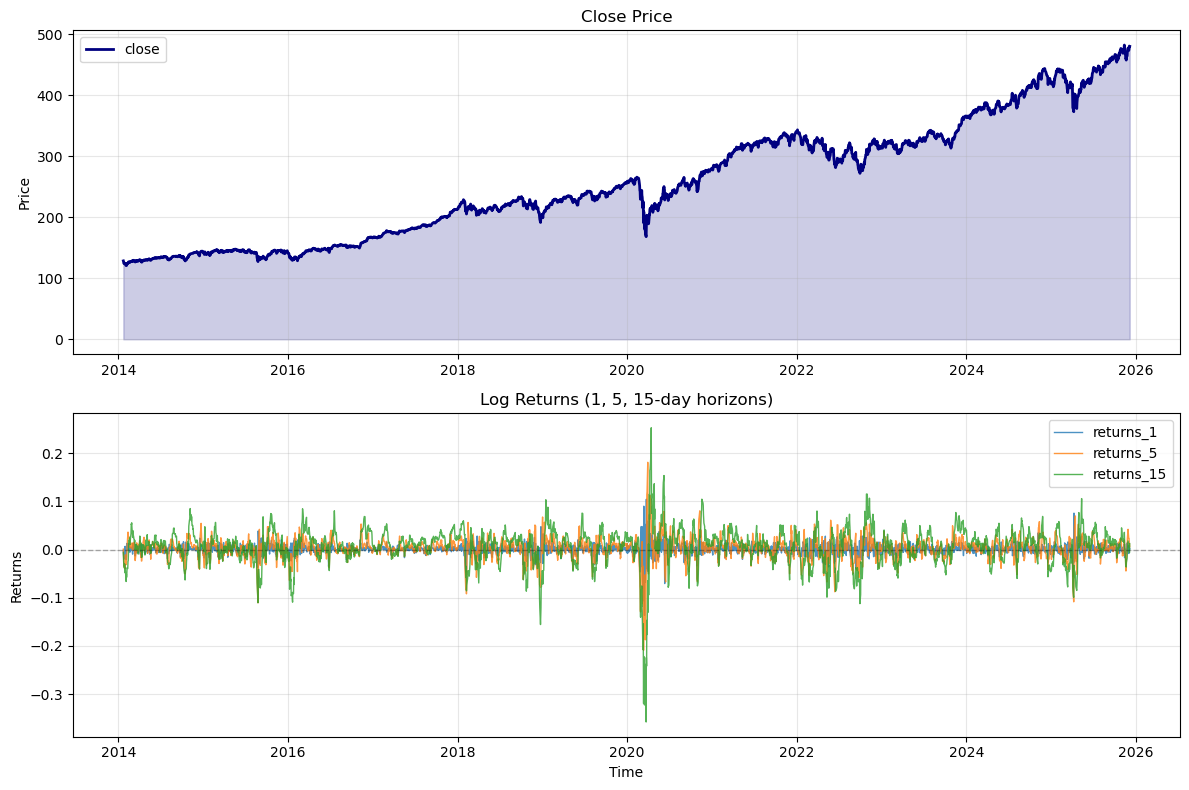

In [10]:
# Cell 5: Quick plotting 
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Close Price
if 'close' in engineered.columns:
    ax1.plot(engineered.index, engineered['close'], label='close', linewidth=2, color='navy')
    ax1.fill_between(engineered.index, engineered['close'], alpha=0.2, color='navy')
    ax1.set_ylabel('Price')
    ax1.set_title('Close Price')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Plot 2: Returns (1, 5, 15 day)
if 'returns_1' in engineered.columns:
    ax2.plot(engineered.index, engineered['returns_1'], label='returns_1', linewidth=1, alpha=0.8)
if 'returns_5' in engineered.columns:
    ax2.plot(engineered.index, engineered['returns_5'], label='returns_5', linewidth=1, alpha=0.8)
if 'returns_15' in engineered.columns:
    ax2.plot(engineered.index, engineered['returns_15'], label='returns_15', linewidth=1, alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
ax2.set_ylabel('Returns')
ax2.set_xlabel('Time')
ax2.set_title('Log Returns (1, 5, 15-day horizons)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


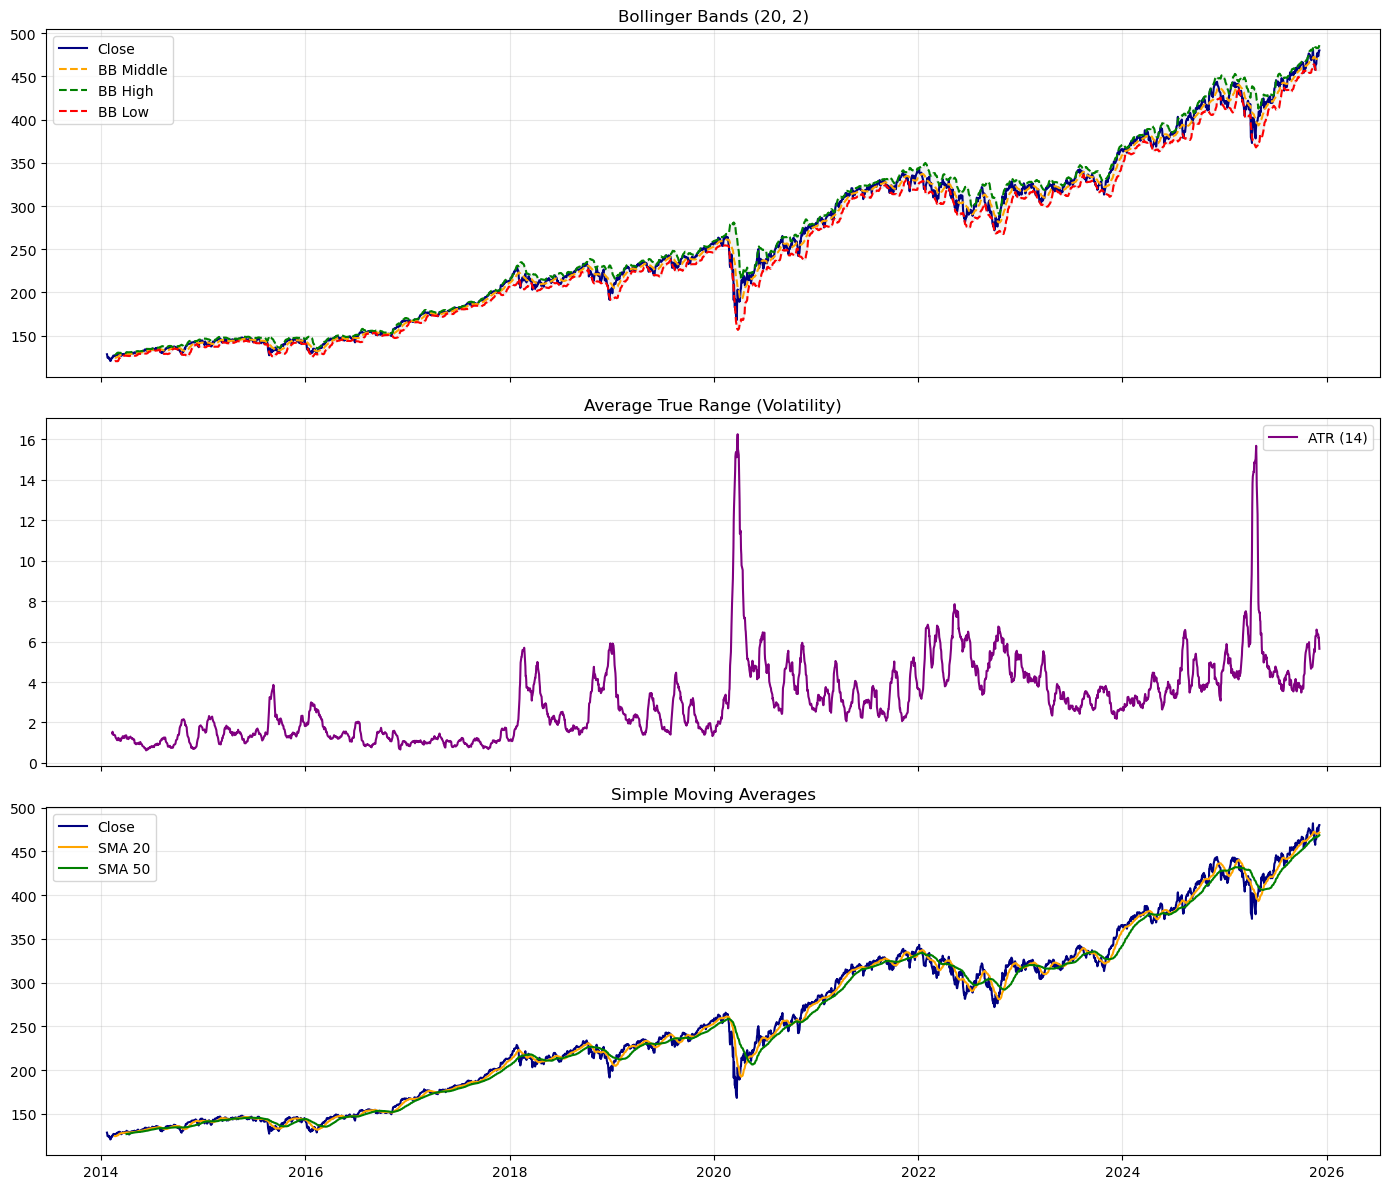

In [11]:
# Most Important Financial Charts (No external TA library)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Bollinger Bands (20, 2) ---
window = 20
engineered['bb_mavg'] = engineered['close'].rolling(window=window).mean()
engineered['bb_std'] = engineered['close'].rolling(window=window).std()
engineered['bb_high'] = engineered['bb_mavg'] + 2 * engineered['bb_std']
engineered['bb_low'] = engineered['bb_mavg'] - 2 * engineered['bb_std']

# --- ATR (Average True Range, 14) ---
atr_window = 14
high_low = engineered['high'] - engineered['low']
high_close = np.abs(engineered['high'] - engineered['close'].shift(1))
low_close = np.abs(engineered['low'] - engineered['close'].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
engineered['atr'] = tr.rolling(window=atr_window).mean()

# --- Simple Moving Averages ---
engineered['sma_20'] = engineered['close'].rolling(window=20).mean()
engineered['sma_50'] = engineered['close'].rolling(window=50).mean()

fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# 1. Bollinger Bands
axs[0].plot(engineered.index, engineered['close'], label='Close', color='navy')
axs[0].plot(engineered.index, engineered['bb_mavg'], label='BB Middle', color='orange', linestyle='--')
axs[0].plot(engineered.index, engineered['bb_high'], label='BB High', color='green', linestyle='--')
axs[0].plot(engineered.index, engineered['bb_low'], label='BB Low', color='red', linestyle='--')
axs[0].fill_between(engineered.index, engineered['bb_high'], engineered['bb_low'], color='gray', alpha=0.1)
axs[0].set_title('Bollinger Bands (20, 2)')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# 2. ATR (Average True Range)
axs[1].plot(engineered.index, engineered['atr'], label='ATR (14)', color='purple')
axs[1].set_title('Average True Range (Volatility)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# 3. Moving Averages
axs[2].plot(engineered.index, engineered['close'], label='Close', color='navy')
axs[2].plot(engineered.index, engineered['sma_20'], label='SMA 20', color='orange')
axs[2].plot(engineered.index, engineered['sma_50'], label='SMA 50', color='green')
axs[2].set_title('Simple Moving Averages')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Debug: Check available columns and generate summary
print("=" * 60)
print("ENGINEERED FEATURES SUMMARY")
print("=" * 60)
print(f"Total features: {len(engineered.columns)}")
print(f"\nAvailable columns in engineered DataFrame:")
print(engineered.columns.tolist())

print("\n" + "=" * 60)
print("FEATURE VERIFICATION FOR PLOTS")
print("=" * 60)
print(f"✓ Returns features: {[c for c in engineered.columns if 'returns' in c]}")
print(f"✓ Volatility features: {[c for c in engineered.columns if 'volatility' in c]}")
print(f"✓ RSI feature: {'rsi' in engineered.columns}")
print(f"✓ MACD features: {[c for c in engineered.columns if 'macd' in c]}")
print(f"✓ Volume feature: {'volume' in engineered.columns}")

print("\n" + "=" * 60)
print("PLOTS GENERATED")
print("=" * 60)
import os
plot_dir = '/workspaces/RL_Intraday_Futures_Strategies/reports/visualizations'
plots = sorted(os.listdir(plot_dir))
for i, plot in enumerate(plots, 1):
    file_size = os.path.getsize(os.path.join(plot_dir, plot)) / 1024  # KB
    print(f"  {i}. {plot:40s} ({file_size:.1f} KB)")
print(f"\n✓ All plots have been regenerated with correct data!")


ENGINEERED FEATURES SUMMARY
Total features: 28

Available columns in engineered DataFrame:
['close', 'high', 'low', 'open', 'volume', 'returns_1', 'returns_5', 'returns_15', 'volatility_5', 'volatility_15', 'volatility_30', 'ma_5', 'ma_15', 'ma_30', 'rsi', 'macd_macd', 'macd_signal', 'macd_histogram', 'imbalance_5', 'imbalance_15', 'spread_proxy', 'bb_mavg', 'bb_std', 'bb_high', 'bb_low', 'atr', 'sma_20', 'sma_50']

FEATURE VERIFICATION FOR PLOTS
✓ Returns features: ['returns_1', 'returns_5', 'returns_15']
✓ Volatility features: ['volatility_5', 'volatility_15', 'volatility_30']
✓ RSI feature: True
✓ MACD features: ['macd_macd', 'macd_signal', 'macd_histogram']
✓ Volume feature: True

PLOTS GENERATED
  1. 01_returns_distribution.png              (82.8 KB)
  2. 02_volatility_over_time.png              (64.5 KB)
  3. 03_technical_indicators.png              (73.2 KB)
  4. 04_price_vs_volume.png                   (208.8 KB)
  5. 05_feature_correlations.png              (249.2 KB)
  6. all

: 

In [ ]:
# Collate images into PDF, build HTML report, create interactive Plotly visuals, and per-ticker charts
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages
import base64
import io
import os
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from src.data.ingestion import DataIngester

reports_dir = Path('/workspaces/RL_Intraday_Futures_Strategies/reports/visualizations')
interactive_dir = Path('/workspaces/RL_Intraday_Futures_Strategies/reports/interactive')
per_ticker_dir = reports_dir / 'per_ticker'
variants_dir = reports_dir / 'variants'
for d in (interactive_dir, per_ticker_dir, variants_dir):
    d.mkdir(parents=True, exist_ok=True)

# 1) Export PNGs to a single PDF
pngs = sorted(reports_dir.glob('*.png'))
pdf_path = reports_dir / 'all_charts.pdf'
with PdfPages(pdf_path) as pdf:
    for p in pngs:
        try:
            img = plt.imread(p)
            fig = plt.figure(figsize=(11, 8.5))
            plt.imshow(img)
            plt.axis('off')
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)
        except Exception as e:
            print('Failed to add', p, e)
print('Saved consolidated PDF:', pdf_path)

# 2) Simple HTML report embedding PNGs (inline as base64)
html_path = reports_dir / 'report.html'
html_parts = ['<html><head><meta charset="utf-8"><title>Data Exploration Report</title></head><body>']
html_parts.append('<h1>Data Exploration Visualizations</h1>')
for p in pngs:
    b = base64.b64encode(p.read_bytes()).decode('ascii')
    html_parts.append(f'<h2>{p.name}</h2>')
    html_parts.append(f'<img src="data:image/png;base64,{b}" style="max-width:100%;height:auto;"/>')
html_parts.append('</body></html>')
html_path.write_text('\n'.join(html_parts), encoding='utf-8')
print('Saved HTML report:', html_path)

# 3) Interactive Plotly versions for key charts
# Prepare data from 'engineered' DataFrame already in notebook scope
try:
    # Price + returns interactive
    fig = go.Figure()
    if 'close' in engineered.columns:
        fig.add_trace(go.Scatter(x=engineered.index, y=engineered['close'], name='Close', line=dict(color='navy')))
    for col in ['returns_1','returns_5','returns_15']:
        if col in engineered.columns:
            fig.add_trace(go.Scatter(x=engineered.index, y=engineered[col], name=col, visible='legendonly'))
    fig.update_layout(title='Close Price and Returns (interactive)', xaxis_title='Time')
    interactive_path = interactive_dir / 'price_returns.html'
    fig.write_html(interactive_path, include_plotlyjs='cdn')
    print('Saved interactive:', interactive_path)

    # Volatility interactive - pick volatility_30 if available
    vol_col = next((c for c in ['volatility_30','volatility_15','volatility_5'] if c in engineered.columns), None)
    if vol_col:
        fig_v = px.line(engineered, x=engineered.index, y=vol_col, title=f'{vol_col} (interactive)')
        interactive_path = interactive_dir / f'{vol_col}.html'
        fig_v.write_html(interactive_path, include_plotlyjs='cdn')
        print('Saved interactive:', interactive_path)

    # RSI & MACD interactive
    if 'rsi' in engineered.columns or 'macd_macd' in engineered.columns:
        fig_t = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['RSI','MACD'])
        if 'rsi' in engineered.columns:
            fig_t.add_trace(go.Scatter(x=engineered.index, y=engineered['rsi'], name='RSI'), row=1, col=1)
        if 'macd_macd' in engineered.columns:
            fig_t.add_trace(go.Scatter(x=engineered.index, y=engineered['macd_macd'], name='MACD'), row=2, col=1)
            if 'macd_signal' in engineered.columns:
                fig_t.add_trace(go.Scatter(x=engineered.index, y=engineered['macd_signal'], name='Signal'), row=2, col=1)
        interactive_path = interactive_dir / 'rsi_macd.html'
        fig_t.update_layout(height=700)
        fig_t.write_html(interactive_path, include_plotlyjs='cdn')
        print('Saved interactive:', interactive_path)
except Exception as e:
    print('Failed to write interactive charts:', e)

# 4) Per-ticker multi-panel charts (close + normalized volume)
try:
    tickers = cfg_ingest.get('data_sources', {}).get('tickers', [])
    if not tickers:
        tickers = []
    if tickers:
        ing = DataIngester(provider=cfg_ingest.get('data_sources', {}).get('provider','yfinance'),
                           tickers=tickers, period='12y', interval='1d', auto_adjust=True)
        multi = ing.fetch(tickers)
        # multi is indexed by (Datetime, ticker)
        for tk in tickers:
            try:
                df_tk = multi.xs(tk, level='ticker') if isinstance(multi.index, pd.MultiIndex) else multi[multi['ticker']==tk]
                if df_tk.empty:
                    continue
                fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), sharex=True)
                ax1.plot(df_tk.index, df_tk['close'], label=f'{tk} Close', color='navy')
                ax1.set_title(f'{tk} Close Price')
                ax1.grid(True, alpha=0.3)
                if 'volume' in df_tk.columns:
                    vol = df_tk['volume']
                    voln = (vol - vol.min())/(vol.max()-vol.min()) if vol.max()>vol.min() else vol
                    ax2.bar(df_tk.index, voln, width=1, color='steelblue', alpha=0.7)
                    ax2.set_title(f'{tk} Volume (normalized)')
                per_path = per_ticker_dir / f'{tk}_price_volume.png'
                plt.tight_layout()
                plt.savefig(per_path, dpi=200, bbox_inches='tight')
                plt.close()
            except Exception as e:
                print('Per-ticker failed for', tk, e)
        print('Saved per-ticker charts to', per_ticker_dir)
except Exception as e:
    print('Per-ticker generation failed:', e)

# 5) Volume-scaling variants for main engineered (log and rolling z-score)
try:
    if 'volume' in engineered.columns:
        vol = engineered['volume'].copy()
        vol_log = np.log1p(vol)
        roll_mean = vol.rolling(window=30, min_periods=1).mean()
        roll_std = vol.rolling(window=30, min_periods=1).std().replace(0,1)
        vol_z = (vol - roll_mean)/roll_std
        # save log plot
        fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
        ax[0].plot(engineered.index, engineered['close'], label='Close')
        ax[0].set_title('Close Price (with log-volume)')
        ax[1].plot(engineered.index, vol_log, label='log(volume)', color='orange')
        ax[1].set_title('Log Volume')
        vpath = variants_dir / 'volume_log.png'
        plt.tight_layout()
        plt.savefig(vpath, dpi=200, bbox_inches='tight')
        plt.close()
        # save z-score plot
        fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
        ax[0].plot(engineered.index, engineered['close'], label='Close')
        ax[0].set_title('Close Price (with zscore-volume)')
        ax[1].plot(engineered.index, vol_z, label='volume_z', color='green')
        ax[1].set_title('Rolling z-score Volume (30-day)')
        vpath2 = variants_dir / 'volume_zscore.png'
        plt.tight_layout()
        plt.savefig(vpath2, dpi=200, bbox_inches='tight')
        plt.close()
        print('Saved volume variant plots to', variants_dir)
except Exception as e:
    print('Failed volume variants:', e)

print('\nDone: PDF, HTML report, interactive charts, per-ticker PNGs, and volume variants generated.')


Saved consolidated PDF: /workspaces/RL_Intraday_Futures_Strategies/reports/visualizations/all_charts.pdf
Saved HTML report: /workspaces/RL_Intraday_Futures_Strategies/reports/visualizations/report.html
Saved interactive: /workspaces/RL_Intraday_Futures_Strategies/reports/interactive/price_returns.html
Saved interactive: /workspaces/RL_Intraday_Futures_Strategies/reports/interactive/price_returns.html
Saved interactive: /workspaces/RL_Intraday_Futures_Strategies/reports/interactive/volatility_30.html
Failed to write interactive charts: name 'make_subplots' is not defined
Saved interactive: /workspaces/RL_Intraday_Futures_Strategies/reports/interactive/volatility_30.html
Failed to write interactive charts: name 'make_subplots' is not defined


/workspaces/RL_Intraday_Futures_Strategies/src/data/ingestion.py:110: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [ ]:
# Fix: generate missing interactive RSI+MACD and per-ticker interactive HTMLs
from plotly.subplots import make_subplots

try:
    # RSI + MACD interactive
    if 'rsi' in engineered.columns or 'macd_macd' in engineered.columns:
        fig_t = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['RSI','MACD'])
        if 'rsi' in engineered.columns:
            fig_t.add_trace(go.Scatter(x=engineered.index, y=engineered['rsi'], name='RSI'), row=1, col=1)
        if 'macd_macd' in engineered.columns:
            fig_t.add_trace(go.Scatter(x=engineered.index, y=engineered['macd_macd'], name='MACD'), row=2, col=1)
            if 'macd_signal' in engineered.columns:
                fig_t.add_trace(go.Scatter(x=engineered.index, y=engineered['macd_signal'], name='Signal'), row=2, col=1)
        fig_t.update_layout(height=700, title='RSI and MACD (interactive)')
        interactive_path = interactive_dir / 'rsi_macd.html'
        fig_t.write_html(interactive_path, include_plotlyjs='cdn')
        print('Saved interactive:', interactive_path)
except Exception as e:
    print('Failed to generate rsi_macd interactive:', e)

# Per-ticker interactive pages
try:
    if 'tickers' in locals() and tickers:
        for tk in tickers:
            try:
                df_tk = multi.xs(tk, level='ticker') if isinstance(multi.index, pd.MultiIndex) else multi[multi['ticker']==tk]
                if df_tk.empty:
                    continue
                figp = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=[f'{tk} Close', f'{tk} Volume'])
                figp.add_trace(go.Scatter(x=df_tk.index, y=df_tk['close'], name=f'{tk} Close'), row=1, col=1)
                if 'volume' in df_tk.columns:
                    figp.add_trace(go.Bar(x=df_tk.index, y=df_tk['volume'], name=f'{tk} Volume'), row=2, col=1)
                outp = interactive_dir / f'{tk}_interactive.html'
                figp.update_layout(height=700, title=f'{tk} interactive')
                figp.write_html(outp, include_plotlyjs='cdn')
            except Exception as e:
                print('Per-ticker interactive failed for', tk, e)
        print('Saved per-ticker interactive pages to', interactive_dir)
except Exception as e:
    print('Per-ticker interactive generation failed overall:', e)

# Mark interactive done
print('Interactive charts generation complete.')


Saved interactive: /workspaces/RL_Intraday_Futures_Strategies/reports/interactive/rsi_macd.html
Saved per-ticker interactive pages to /workspaces/RL_Intraday_Futures_Strategies/reports/interactive
Interactive charts generation complete.
Saved per-ticker interactive pages to /workspaces/RL_Intraday_Futures_Strategies/reports/interactive
Interactive charts generation complete.
